# DEX Data Analysis

Load and analyze DEX trading data from The Graph subgraphs.

In [2]:
import json
import os
import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in dir() else Path.cwd().parent


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [3]:
def load_dex_data(subgraph: str, query_type: str) -> pd.DataFrame:
    """
    Load DEX data from the data directory as a pandas DataFrame.
    
    Args:
        subgraph: The subgraph name (e.g., 'uniswap_v3_ethereum', 'pancakeswap_v3_bsc')
        query_type: The query type ('pools', 'swaps', or 'tokens')
        
    Returns:
        pandas DataFrame with the query results
        
    Example:
        df = load_dex_data('uniswap_v3_ethereum', 'swaps')
    """
    data_path = PROJECT_ROOT / 'data' / subgraph / query_type / 'data.json'
    
    if not data_path.exists():
        raise FileNotFoundError(
            f"Data file not found: {data_path}\n"
            f"Run: python thegraph_dex_downloader.py --subgraph {subgraph} --query-type {query_type}"
        )
    
    with open(data_path, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    
    # Convert timestamp columns to datetime if present
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df

In [4]:
def list_available_data() -> dict:
    """
    List all available downloaded data.
    
    Returns:
        Dictionary mapping subgraph names to lists of available query types
    """
    data_dir = PROJECT_ROOT / 'data'
    available = {}
    
    if not data_dir.exists():
        print("No data directory found. Run thegraph_dex_downloader.py first.")
        return available
    
    for subgraph_dir in data_dir.iterdir():
        if subgraph_dir.is_dir():
            query_types = []
            for query_dir in subgraph_dir.iterdir():
                if query_dir.is_dir() and (query_dir / 'data.json').exists():
                    query_types.append(query_dir.name)
            if query_types:
                available[subgraph_dir.name] = query_types
    
    return available

# Show available data
available = list_available_data()
if available:
    print("Available data:")
    for subgraph, query_types in available.items():
        print(f"  {subgraph}: {', '.join(query_types)}")
else:
    print("No data available yet. Run the downloader script first.")

Available data:
  uniswap_v3_ethereum: swaps
  uniswap_v3_arbitrum: swaps
  pancakeswap_v3_bsc: pools
  pancakeswap_v3_ethereum: swaps


## Usage Example

Load data by specifying the subgraph and query type:

In [5]:
# Example: Load data (uncomment and modify as needed)
# df_psp = load_dex_data('pancakeswap_v3_bsc', 'pools')
df = load_dex_data('uniswap_v3_ethereum', 'swaps')
df = df.assign(price = abs(df['amount0'] / df['amount1']))
df.head()

,id,tx_hash,block_number,timestamp,datetime,pool_id,pair,amount0,amount1,amount_usd,sender,recipient,price
0,0xe9b0db62436a889471394bb46b4a3307cc9b12828a1b...,0xe9b0db62436a889471394bb46b4a3307cc9b12828a1b...,23920030,2025-12-01 17:09:59,2025-12-01 11:09:59,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC/WETH,-10.500000,0.003840,10.506103,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,2734.344021
1,0x97ddb84f4acbb0433f8cd7e30c1cacff7dca7503d7c0...,0x97ddb84f4acbb0433f8cd7e30c1cacff7dca7503d7c0...,23920030,2025-12-01 17:09:59,2025-12-01 11:09:59,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC/WETH,-17461.007876,6.383507,17468.001328,0xa836912dce3b96cb9f3f1bf2406d6491ed601f66,0xa836912dce3b96cb9f3f1bf2406d6491ed601f66,2735.331592
2,0x02d52d8caef222aa9da34fefa3416f11b9b366240474...,0x02d52d8caef222aa9da34fefa3416f11b9b366240474...,23920030,2025-12-01 17:09:59,2025-12-01 11:09:59,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC/WETH,176.941596,-0.064646,176.955587,0x66a9893cc07d91d95644aedd05d03f95e1dba8af,0x66a9893cc07d91d95644aedd05d03f95e1dba8af,2737.089833
3,0x2a82d0f1c872584940b84f271e119f342dcfa066f910...,0x2a82d0f1c872584940b84f271e119f342dcfa066f910...,23920029,2025-12-01 17:09:47,2025-12-01 11:09:47,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC/WETH,-20188.305480,7.374830,20188.534900,0xfbd4cdb413e45a52e2c8312f670e9ce67e794c37,0xfbd4cdb413e45a52e2c8312f670e9ce67e794c37,2737.460475
4,0x9c5203f3ee2ddff0a2bf469181cf8be95e6015f61f63...,0x9c5203f3ee2ddff0a2bf469181cf8be95e6015f61f63...,23920028,2025-12-01 17:09:35,2025-12-01 11:09:35,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC/WETH,-2350.298369,0.858169,2349.777992,0x365084b05fa7d5028346bd21d842ed0601bab5b8,0x365084b05fa7d5028346bd21d842ed0601bab5b8,2738.735454


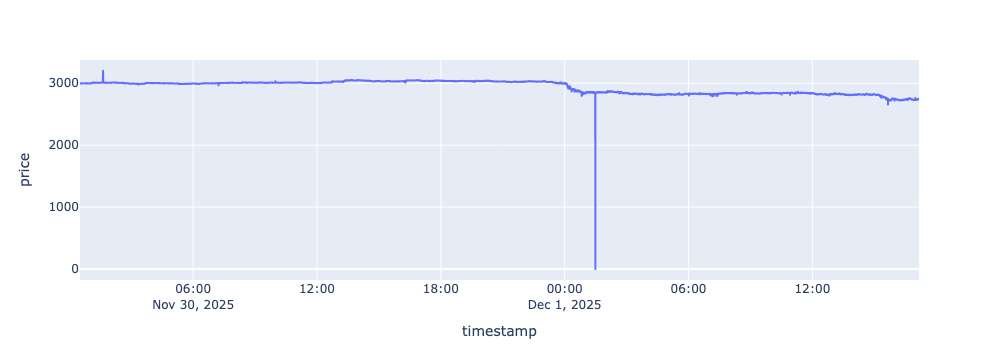

In [7]:
px.line(df, 'timestamp', 'price')